# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr
import copy
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Model Definition

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

class MLP(nn.Module):
   def __init__(self):
       """ Initialization of the MLP
           Creates a sequential neural network with:
           - Input layer: 784 features (28x28 MNIST pixels) -> 128 hidden units
           - Three hidden layers: each with 128 units and ReLU activation
           - Output layer: 128 -> 10 classes (digits 0-9)
       """
       super(MLP, self).__init__()
       self.layers = nn.Sequential(
           nn.Linear(784, 128),
           nn.ReLU(),
           nn.Linear(128, 128),
           nn.ReLU(),
           nn.Linear(128, 128),
           nn.ReLU(),
           nn.Linear(128, 10)
       )
   
   def forward(self, x):
       """ Forward pass through the network
           INPUT:
               x = tensor (batch_size, 1, 28, 28) - MNIST images
           OUTPUT:
               tensor (batch_size, 10) - class logits
       """
       x = x.view(-1, 784)  # Flatten the input
       return self.layers(x)
   
   def get_features(self, x):
       """ Extract intermediate representations for analysis
           INPUT:
               x = tensor (batch_size, 1, 28, 28) - MNIST images
           OUTPUT:
               features = list of tensors - activations after each ReLU layer
       """
       """Extract intermediate representations for analysis"""
       x = x.view(-1, 784)
       features = []
       for i, layer in enumerate(self.layers):
           x = layer(x)
           if isinstance(layer, nn.ReLU):
               features.append(x.clone().detach())
       return features

# Convex-like Behavior experiment

Using device: cuda
Train samples: 60000, Test samples: 10000
Starting Convex-like Behavior Experiment
Training run 1/8
  Epoch 10: Loss=0.0265, Grad_norm=0.4947, Test_acc=0.9765
  Epoch 20: Loss=0.0095, Grad_norm=0.3536, Test_acc=0.9748
  Epoch 30: Loss=0.0045, Grad_norm=0.2025, Test_acc=0.9793
Training run 2/8
  Epoch 10: Loss=0.0245, Grad_norm=0.4685, Test_acc=0.9765
  Epoch 20: Loss=0.0124, Grad_norm=0.3876, Test_acc=0.9734
  Epoch 30: Loss=0.0101, Grad_norm=0.3576, Test_acc=0.9771
Training run 3/8
  Epoch 10: Loss=0.0270, Grad_norm=0.5003, Test_acc=0.9777
  Epoch 20: Loss=0.0087, Grad_norm=0.3106, Test_acc=0.9730
  Epoch 30: Loss=0.0032, Grad_norm=0.1511, Test_acc=0.9790
Training run 4/8
  Epoch 10: Loss=0.0242, Grad_norm=0.4730, Test_acc=0.9744
  Epoch 20: Loss=0.0127, Grad_norm=0.3958, Test_acc=0.9761
  Epoch 30: Loss=0.0062, Grad_norm=0.2477, Test_acc=0.9808
Training run 5/8
  Epoch 10: Loss=0.0263, Grad_norm=0.5026, Test_acc=0.9746
  Epoch 20: Loss=0.0094, Grad_norm=0.3347, Tes

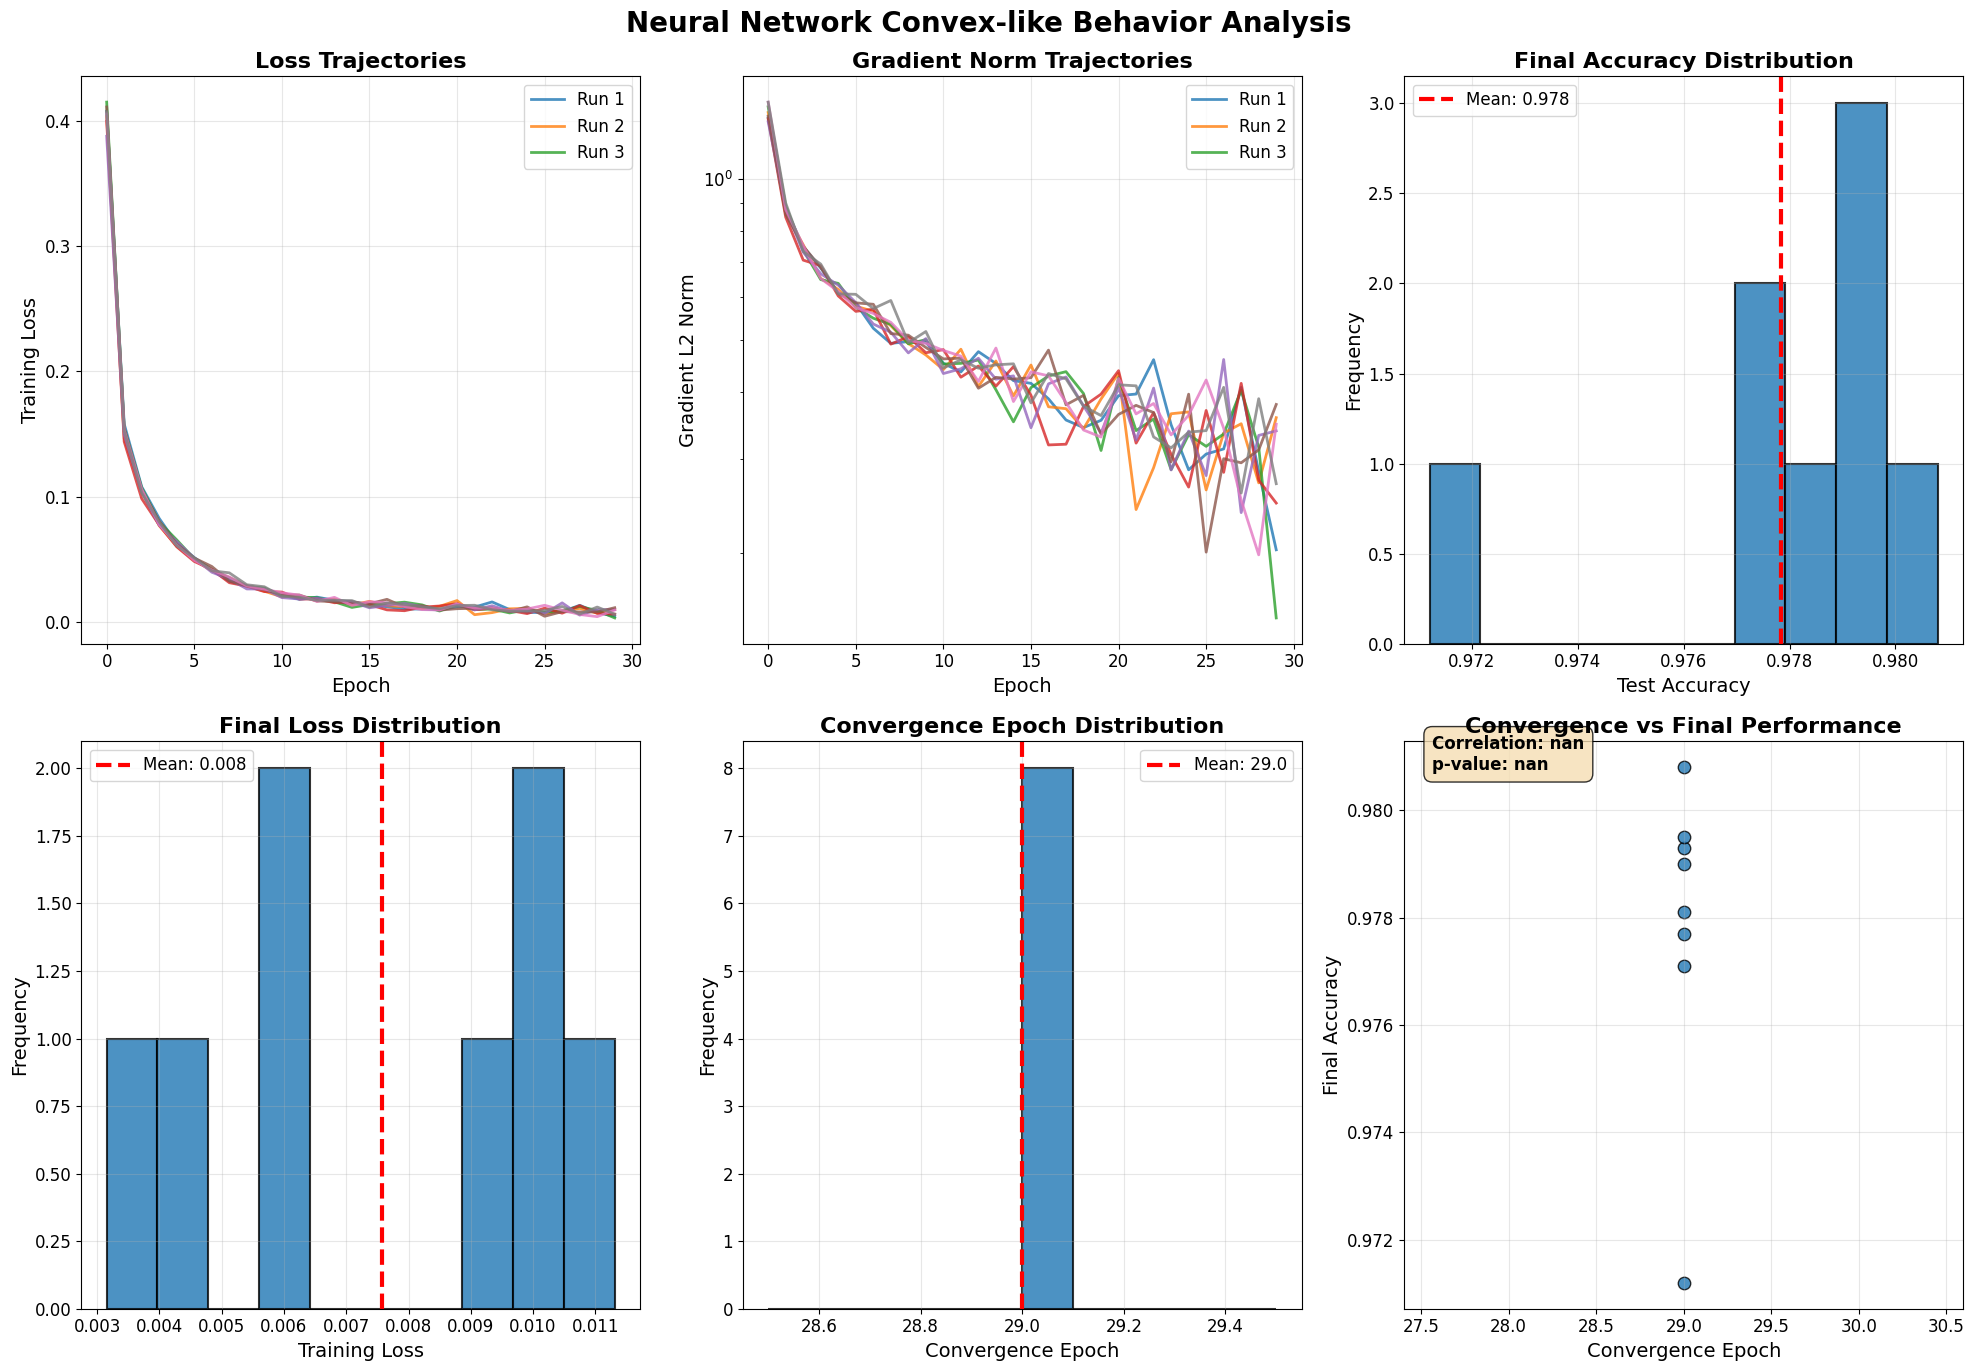


Convex-like Behavior Score: 0.992
(Higher score indicates more convex-like behavior)


In [ ]:
class ConvexBehaviorExperiment:
   # Initialisation
   def __init__(self, num_runs=10, epochs=50, lr=0.001):
       """ Initialization of the ConvexBehaviorExperiment
           INPUT:
               num_runs = int (number of independent training runs to perform)
               epochs = int (number of training epochs per run)
               lr = float (learning rate for the optimizer)
           Sets up device, loads MNIST data, and initializes result storage
       """
       self.num_runs = num_runs
       self.epochs = epochs
       self.lr = lr
       self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
       print(f"Using device: {self.device}")
       
       # Load MNIST dataset
       self.load_data()
       
       # Storage for results
       self.results = {
           'loss_trajectories': [],
           'gradient_norms': [],
           'final_weights': [],
           'final_accuracies': [],
           'final_losses': [],
           'convergence_epochs': []
       }
   
   def load_data(self):
       """ Load MNIST dataset with specified split
           Creates train and test dataloaders with 60k/10k samples respectively
           Applies normalization transform to the data
       """
       """Load MNIST dataset with specified split"""
       transform = transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))
       ])
       
       # Load full datasets
       full_train = datasets.MNIST('data', train=True, download=True, transform=transform)
       full_test = datasets.MNIST('data', train=False, download=True, transform=transform)
       
       # Create subset with 60k train, 10k test
       train_indices = torch.randperm(len(full_train))[:60000]
       test_indices = torch.randperm(len(full_test))[:10000]
       
       train_subset = torch.utils.data.Subset(full_train, train_indices)
       test_subset = torch.utils.data.Subset(full_test, test_indices)
       
       self.train_loader = DataLoader(train_subset, batch_size=256, shuffle=True)
       self.test_loader = DataLoader(test_subset, batch_size=1000, shuffle=False)
       
       print(f"Train samples: {len(train_subset)}, Test samples: {len(test_subset)}")
   
   def compute_gradient_norm(self, model):
       """ Compute L2 norm of gradients
           INPUT:
               model = torch.nn.Module (neural network model)
           OUTPUT:
               float (L2 norm of all gradients in the model)
       """
       """Compute L2 norm of gradients"""
       total_norm = 0.0
       for param in model.parameters():
           if param.grad is not None:
               param_norm = param.grad.data.norm(2)
               total_norm += param_norm.item() ** 2
       return total_norm ** 0.5
   
   def train_single_model(self, run_id):
       """ Train a single model and track metrics
           INPUT:
               run_id = int (unique identifier for this training run)
           OUTPUT:
               model = torch.nn.Module (trained model)
           Tracks loss trajectories, gradient norms, and final performance
       """
       """Train a single model and track metrics"""
       print(f"Training run {run_id + 1}/{self.num_runs}")
       
       # Initialize model with different random seed for each run
       torch.manual_seed(run_id * 1000 + 42)
       model = MLP().to(self.device)
       optimizer = optim.Adam(model.parameters(), lr=self.lr)
       criterion = nn.CrossEntropyLoss()
       
       # Track metrics for this run
       loss_trajectory = []
       gradient_norms = []
       
       for epoch in range(self.epochs):
           model.train()
           epoch_loss = 0.0
           epoch_grad_norm = 0.0
           num_batches = 0
           
           for batch_idx, (data, target) in enumerate(self.train_loader):
               data, target = data.to(self.device), target.to(self.device)
               
               optimizer.zero_grad()
               output = model(data)
               loss = criterion(output, target)
               loss.backward()
               
               # Track gradient norm
               grad_norm = self.compute_gradient_norm(model)
               epoch_grad_norm += grad_norm
               
               optimizer.step()
               epoch_loss += loss.item()
               num_batches += 1
           
           avg_loss = epoch_loss / num_batches
           avg_grad_norm = epoch_grad_norm / num_batches
           
           loss_trajectory.append(avg_loss)
           gradient_norms.append(avg_grad_norm)
           
           if (epoch + 1) % 10 == 0:
               test_acc = self.evaluate_model(model)
               print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f}, Grad_norm={avg_grad_norm:.4f}, Test_acc={test_acc:.4f}")
       
       # Final evaluation
       final_accuracy = self.evaluate_model(model)
       final_loss = loss_trajectory[-1]
       
       # Find convergence epoch (when loss change becomes small)
       convergence_epoch = self.find_convergence_epoch(loss_trajectory)
       
       # Store results
       self.results['loss_trajectories'].append(loss_trajectory)
       self.results['gradient_norms'].append(gradient_norms)
       self.results['final_weights'].append(self.extract_weights(model))
       self.results['final_accuracies'].append(final_accuracy)
       self.results['final_losses'].append(final_loss)
       self.results['convergence_epochs'].append(convergence_epoch)
       
       return model
   
   def evaluate_model(self, model):
       """ Evaluate model accuracy on test set
           INPUT:
               model = torch.nn.Module (neural network model to evaluate)
           OUTPUT:
               float (test accuracy as fraction between 0 and 1)
       """
       """Evaluate model accuracy on test set"""
       model.eval()
       correct = 0
       total = 0
       
       with torch.no_grad():
           for data, target in self.test_loader:
               data, target = data.to(self.device), target.to(self.device)
               output = model(data)
               pred = output.argmax(dim=1)
               correct += pred.eq(target).sum().item()
               total += target.size(0)
       
       return correct / total
   
   def extract_weights(self, model):
       """ Extract flattened weights for comparison
           INPUT:
               model = torch.nn.Module (neural network model)
           OUTPUT:
               np.array (1D array containing all model parameters flattened)
       """
       """Extract flattened weights for comparison"""
       weights = []
       for param in model.parameters():
           weights.extend(param.data.cpu().numpy().flatten())
       return np.array(weights)
   
   def find_convergence_epoch(self, loss_trajectory, threshold=0.001):
       """ Find epoch where loss change becomes smaller than threshold
           INPUT:
               loss_trajectory = list (loss values across epochs)
               threshold = float (threshold for considering convergence)
           OUTPUT:
               int (epoch number where convergence occurred)
       """
       """Find epoch where loss change becomes smaller than threshold"""
       for i in range(5, len(loss_trajectory)):
           recent_changes = [abs(loss_trajectory[j] - loss_trajectory[j-1]) 
                           for j in range(i-4, i)]
           if all(change < threshold for change in recent_changes):
               return i
       return len(loss_trajectory) - 1
   
   def run_experiment(self):
       """ Run the full experiment
           Executes all training runs and analyzes results for convex-like behavior
       """
       """Run the full experiment"""
       print("Starting Convex-like Behavior Experiment")        
       for run_id in range(self.num_runs):
           self.train_single_model(run_id)
       
       self.analyze_results()
   
   def analyze_results(self):
       """ Analyze results to test convex-like behavior
           Computes statistics on performance consistency, weight similarity,
           gradient behavior, and creates visualizations
       """
       """Analyze results to test convex-like behavior"""
       
       # 1. Consistency of final performance (convex-like property)
       final_accs = np.array(self.results['final_accuracies'])
       final_losses = np.array(self.results['final_losses'])
       
       print(f"Final Accuracy - Mean: {final_accs.mean():.4f}, Std: {final_accs.std():.4f}")
       print(f"Final Loss - Mean: {final_losses.mean():.4f}, Std: {final_losses.std():.4f}")
       print(f"Accuracy Range: {final_accs.max() - final_accs.min():.4f}")
       print(f"Loss Range: {final_losses.max() - final_losses.min():.4f}")
       
       # 2. Convergence consistency
       conv_epochs = np.array(self.results['convergence_epochs'])
       print(f"Convergence Epoch - Mean: {conv_epochs.mean():.1f}, Std: {conv_epochs.std():.1f}")
       
       # 3. Weight similarity analysis
       self.analyze_weight_similarity()
       
       # 4. Gradient behavior analysis
       self.analyze_gradient_behavior()
       
       # 5. Create visualizations (only the main figure with 6 subplots)
       self.create_visualizations()
       
       # 6. Convex-like behavior score
       convex_score = self.compute_convex_score()
   
   def analyze_weight_similarity(self):
       """ Analyze similarity between final weights of different runs
           Computes cosine similarity and normalized L2 distances between
           final weight vectors from different training runs
       """
       """Analyze similarity between final weights of different runs"""
       print(f"\nWeight Similarity Analysis:")
       
       final_weights = self.results['final_weights']
       similarities = []
       
       for i in range(len(final_weights)):
           for j in range(i+1, len(final_weights)):
               # Compute cosine similarity
               w1, w2 = final_weights[i], final_weights[j]
               similarity = np.dot(w1, w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
               similarities.append(similarity)
       
       similarities = np.array(similarities)
       print(f"Weight Cosine Similarity - Mean: {similarities.mean():.4f}, Std: {similarities.std():.4f}")
       
       # Also compute pairwise L2 distances (normalized)
       distances = []
       for i in range(len(final_weights)):
           for j in range(i+1, len(final_weights)):
               w1, w2 = final_weights[i], final_weights[j]
               distance = np.linalg.norm(w1 - w2) / (np.linalg.norm(w1) + np.linalg.norm(w2))
               distances.append(distance)
       
       distances = np.array(distances)
       print(f"Normalized Weight Distance - Mean: {distances.mean():.4f}, Std: {distances.std():.4f}")
   
   def analyze_gradient_behavior(self):
       """ Analyze gradient behavior across runs
           Computes correlations between gradient trajectories and examines
           final gradient norms for consistency across runs
       """
       """Analyze gradient behavior across runs"""
       print(f"\nGradient Behavior Analysis:")
       
       # Check if gradient norms follow similar patterns
       all_grad_norms = np.array(self.results['gradient_norms'])
       
       # Compute correlation between gradient trajectories of different runs
       correlations = []
       for i in range(len(all_grad_norms)):
           for j in range(i+1, len(all_grad_norms)):
               corr, _ = pearsonr(all_grad_norms[i], all_grad_norms[j])
               correlations.append(corr)
       
       correlations = np.array(correlations)
       print(f"Gradient Trajectory Correlation - Mean: {correlations.mean():.4f}, Std: {correlations.std():.4f}")
       
       # Final gradient norms
       final_grad_norms = [norms[-1] for norms in self.results['gradient_norms']]
       print(f"Final Gradient Norms - Mean: {np.mean(final_grad_norms):.6f}, Std: {np.std(final_grad_norms):.6f}")
   
   def compute_convex_score(self):
       """ Compute a score indicating how convex-like the behavior is
           INPUT: None (uses stored results)
           OUTPUT:
               float (convex behavior score between 0 and 1, higher = more convex-like)
           Combines metrics of consistency, convergence, and gradient similarity
       """
       """Compute a score indicating how convex-like the behavior is"""
       # Combine multiple metrics into a single score
       
       # 1. Consistency of final performance
       acc_consistency = 1 / (1 + np.std(self.results['final_accuracies']))
       loss_consistency = 1 / (1 + np.std(self.results['final_losses']))
       
       # 2. Convergence consistency
       conv_consistency = 1 / (1 + np.std(self.results['convergence_epochs']) / 10)
       
       # 3. Gradient correlation 
       all_grad_norms = np.array(self.results['gradient_norms'])
       correlations = []
       for i in range(len(all_grad_norms)):
           for j in range(i+1, len(all_grad_norms)):
               corr, _ = pearsonr(all_grad_norms[i], all_grad_norms[j])
               correlations.append(corr)
       grad_similarity = np.mean(correlations)
       
       # Combine scores (weights can be adjusted)
       convex_score = (0.3 * acc_consistency + 0.3 * loss_consistency + 
                      0.2 * conv_consistency + 0.2 * grad_similarity)
       
       return convex_score
   
   def create_visualizations(self):
       """ Create visualizations of the results with enhanced font sizes for reports
           Generates a 2x3 subplot figure showing loss trajectories, gradient norms,
           performance distributions, convergence analysis, and scatter plots
       """
       """Create visualizations of the results with enhanced font sizes for reports"""
       # Set global font sizes for matplotlib
       plt.rcParams.update({
           'font.size': 14,          # Base font size
           'axes.titlesize': 16,     # Subplot titles
           'axes.labelsize': 14,     # Axis labels
           'xtick.labelsize': 12,    # X-axis tick labels
           'ytick.labelsize': 12,    # Y-axis tick labels
           'legend.fontsize': 12,    # Legend
           'figure.titlesize': 18    # Main title
       })
       
       fig, axes = plt.subplots(2, 3, figsize=(20, 14))  
       fig.suptitle('Neural Network Convex-like Behavior Analysis', fontsize=20, fontweight='bold')
       
       # 1. Loss trajectories
       ax = axes[0, 0]
       for i, trajectory in enumerate(self.results['loss_trajectories']):
           ax.plot(trajectory, alpha=0.8, linewidth=2, label=f'Run {i+1}' if i < 3 else '')
       ax.set_title('Loss Trajectories', fontsize=16, fontweight='bold')
       ax.set_xlabel('Epoch', fontsize=14)
       ax.set_ylabel('Training Loss', fontsize=14)
       ax.legend(fontsize=12)
       ax.grid(True, alpha=0.3)
       ax.tick_params(labelsize=12)
       
       # 2. Gradient norms
       ax = axes[0, 1]
       for i, grad_norms in enumerate(self.results['gradient_norms']):
           ax.plot(grad_norms, alpha=0.8, linewidth=2, label=f'Run {i+1}' if i < 3 else '')
       ax.set_title('Gradient Norm Trajectories', fontsize=16, fontweight='bold')
       ax.set_xlabel('Epoch', fontsize=14)
       ax.set_ylabel('Gradient L2 Norm', fontsize=14)
       ax.legend(fontsize=12)
       ax.grid(True, alpha=0.3)
       ax.set_yscale('log')
       ax.tick_params(labelsize=12)
       
       # 3. Final performance distribution
       ax = axes[0, 2]
       ax.hist(self.results['final_accuracies'], bins=10, alpha=0.8, edgecolor='black', linewidth=1.5)
       ax.set_title('Final Accuracy Distribution', fontsize=16, fontweight='bold')
       ax.set_xlabel('Test Accuracy', fontsize=14)
       ax.set_ylabel('Frequency', fontsize=14)
       mean_acc = np.mean(self.results['final_accuracies'])
       ax.axvline(mean_acc, color='red', linewidth=3,
                 linestyle='--', label=f'Mean: {mean_acc:.3f}')
       ax.legend(fontsize=12)
       ax.grid(True, alpha=0.3)
       ax.tick_params(labelsize=12)
       
       # 4. Final loss distribution
       ax = axes[1, 0]
       ax.hist(self.results['final_losses'], bins=10, alpha=0.8, edgecolor='black', linewidth=1.5)
       ax.set_title('Final Loss Distribution', fontsize=16, fontweight='bold')
       ax.set_xlabel('Training Loss', fontsize=14)
       ax.set_ylabel('Frequency', fontsize=14)
       mean_loss = np.mean(self.results['final_losses'])
       ax.axvline(mean_loss, color='red', linewidth=3,
                 linestyle='--', label=f'Mean: {mean_loss:.3f}')
       ax.legend(fontsize=12)
       ax.grid(True, alpha=0.3)
       ax.tick_params(labelsize=12)
       
       # 5. Convergence epochs
       ax = axes[1, 1]
       ax.hist(self.results['convergence_epochs'], bins=10, alpha=0.8, edgecolor='black', linewidth=1.5)
       ax.set_title('Convergence Epoch Distribution', fontsize=16, fontweight='bold')
       ax.set_xlabel('Convergence Epoch', fontsize=14)
       ax.set_ylabel('Frequency', fontsize=14)
       mean_conv = np.mean(self.results['convergence_epochs'])
       ax.axvline(mean_conv, color='red', linewidth=3,
                 linestyle='--', label=f'Mean: {mean_conv:.1f}')
       ax.legend(fontsize=12)
       ax.grid(True, alpha=0.3)
       ax.tick_params(labelsize=12)
       
       # 6. Performance vs convergence scatter
       ax = axes[1, 2]
       ax.scatter(self.results['convergence_epochs'], self.results['final_accuracies'], 
                 alpha=0.8, s=80, edgecolors='black', linewidth=1)
       ax.set_title('Convergence vs Final Performance', fontsize=16, fontweight='bold')
       ax.set_xlabel('Convergence Epoch', fontsize=14)
       ax.set_ylabel('Final Accuracy', fontsize=14)
       ax.grid(True, alpha=0.3)
       ax.tick_params(labelsize=12)
       
       # Add correlation coefficient with larger text
       corr, p_val = pearsonr(self.results['convergence_epochs'], self.results['final_accuracies'])
       ax.text(0.05, 0.95, f'Correlation: {corr:.3f}\np-value: {p_val:.3f}', 
              transform=ax.transAxes, fontsize=12, fontweight='bold',
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.5))
       
       plt.tight_layout()
       
       # Save the figure in high resolution for reports
       plt.savefig('convex_behavior_analysis.png', dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
       plt.savefig('convex_behavior_analysis.pdf', bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
       
       plt.show()

# Run the experiment
if __name__ == "__main__":
   # Create and run experiment
   experiment = ConvexBehaviorExperiment(num_runs=8, epochs=30, lr=0.001)
   experiment.run_experiment()